# Notebook Purpose
Now that we have our data set matched up we can do some exploratory analysis to see what we are working with:

## Load Libraries and Data

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [122]:
reviews = pd.read_parquet('data/matches_cleanstyles.parquet')

## Convenience Functions for Plots
Since we'll always want things like titles, these help keep our code concise later on with sensible defaults.

In [16]:
def showplot(data, plot, title, xlab, ylab, kde=False, color=None, figsize='wide',
             xmax = None, bins = None, x=None, y=None, fontscale = 1):
    
    # some nice preset sizes
    figsizes = {
        'small':(10,6),
        'wide':(18,6),
        'large':(18,12)
    }
    # pick the preset size
    sns.set(rc={'figure.figsize':figsizes.get(figsize)})
    
    # pick the chosen type
    if plot == 'dist':
        myplot = sns.distplot(data, kde=kde, color=color, bins=bins),
    elif plot == 'bar':
        myplot = sns.barplot( x=x, y=y, data=data, color=color)
    else:
        raise ('Provide a plot type!')

    # add labels
    plt.title(title, fontsize=18)
    plt.xlabel(xlab, fontsize=16)
    plt.ylabel(ylab, fontsize=16)
    sns.set(font_scale=fontscale)
    
    # change xscale if needed
    if xmax is not None:
        plt.xlim(0,xmax)
    
    # save to disk so we can display in readme
    plt.savefig('images/'+title)

## Normalize Reviews

To normalize reviews, let's set the threshold at 10 reviews per user. For 10 or above we will normalize by user, for below amongst all below..

In [28]:
reviews['count'] = reviews.groupby('username')['rating'].transform('count')

In [60]:
pd.options.mode.chained_assignment = None 
threshold = 5

abovethreshold = reviews[reviews['count'] >= threshold]

abovethreshold['min'] = abovethreshold.groupby('username')['rating'].transform('min')
abovethreshold['max'] = abovethreshold.groupby('username')['rating'].transform('max')
abovethreshold = abovethreshold.assign(rating_normalized = lambda x: round(100*(x['rating'] - x['min'])/(x['max']-x['min'])))

belowthreshold = reviews[reviews['count'] < threshold]
belowthreshold['min'] = belowthreshold['rating'].min()
belowthreshold['max'] = belowthreshold['rating'].max()
belowthreshold = belowthreshold.assign(rating_normalized = lambda x: round(100*(x['rating'] - x['min'])/(x['max']-x['min'])))

reviewsnormalized = pd.concat([abovethreshold,belowthreshold])

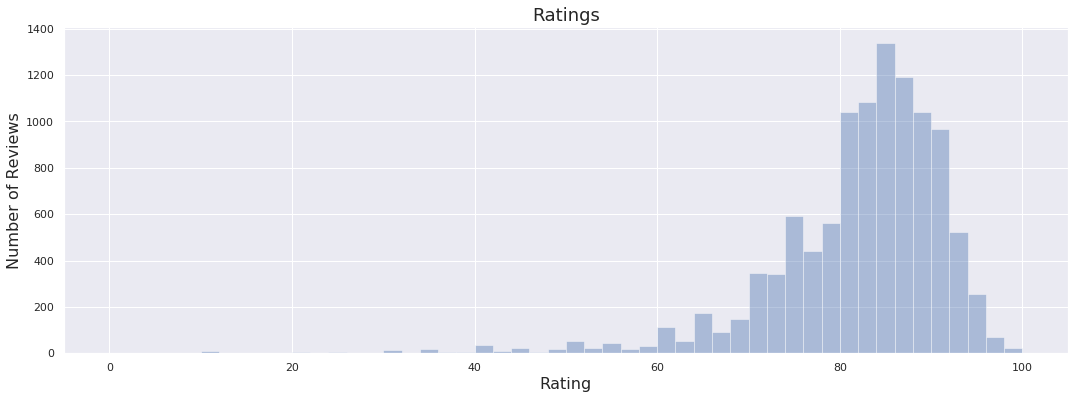

In [54]:
# before
showplot(reviewsnormalized['rating'], 'dist', 'Ratings', 'Rating', 'Number of Reviews')  

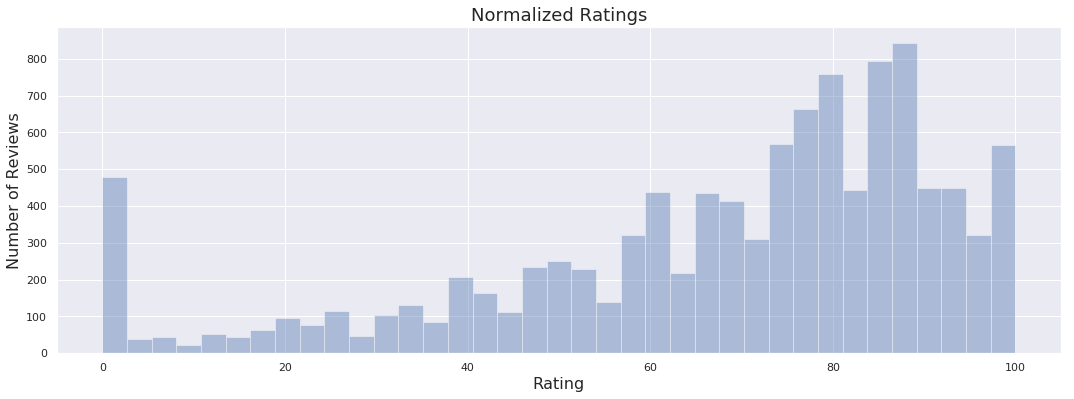

In [61]:
# after
showplot(reviewsnormalized['rating_normalized'], 'dist', 'Normalized Ratings', 'Rating', 'Number of Reviews')  

Normalizing the reviews actually does not help very much since the reviews span from 0 - 100. For it to be effective we would need more than 1 review per user.

Instead we can flag reviews in ranges of quality.

## Qualify Reviews
In order to classify the reviews I'll look at the mean rating and take a standard deviation value above or below to classify

In [72]:
ratingmean = reviews['rating'].mean()
ratingmedian = reviews['rating'].median()
ratingstd = reviews['rating'].std()
print('mean: ' + str(ratingmean))
print('median: ' + str(ratingmedian))
print('std: ' + str(ratingstd))

mean: 81.47968691762952
median: 84.0
std: 9.90376098115754


Let's choose thresholds and classify accordingly:

In [100]:
value_excellent

101.2872088799446

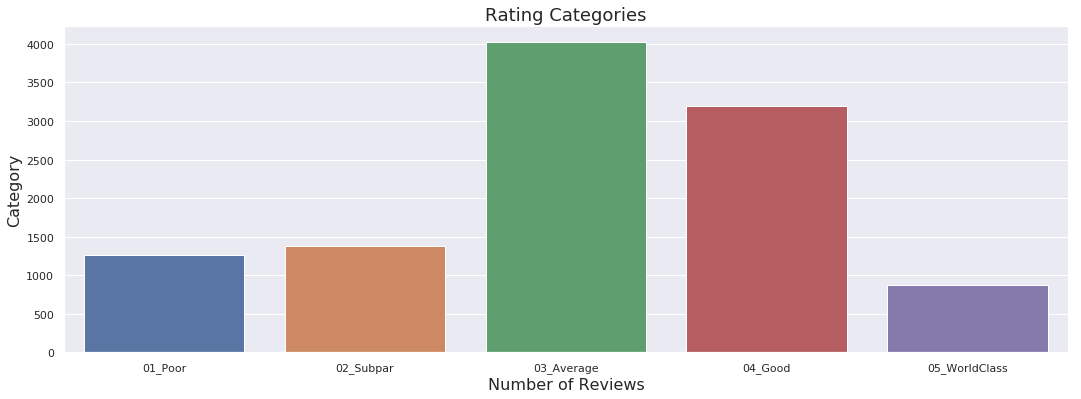

In [150]:
thresholdgood = 0.4
thresholdexcellent = 1

value_subpar = ratingmean - thresholdexcellent*ratingstd
value_average = ratingmean - thresholdgood*ratingstd
value_good = ratingmean + thresholdgood*ratingstd
value_excellent = ratingmean + thresholdexcellent*ratingstd

def rating_cat(rating):
    if rating is None:
        return '03_Average'
    elif rating < value_subpar:
        return '01_Poor'
    elif rating < value_average:
        return '02_Subpar'
    elif rating < value_good:
        return '03_Average'
    elif rating < value_excellent:
        return '04_Good'
    else:
        return '05_WorldClass'
    
reviews['rating_cat'] = reviews[['rating']].apply(lambda x: rating_cat(*x), axis=1)

# show plot of category distribution
categorycount = (pd.DataFrame(reviews.groupby('rating_cat')['rating'].count())
     .reset_index()
     .rename({'rating':'count'}, axis='columns')
     .sort_values(by='rating_cat')
)
showplot(categorycount, 'bar', 'Rating Categories', 'Number of Reviews', 'Category',
         y='count', x='rating_cat')  

This looks like a more useful indicator of quality to our users.

Save to file

In [153]:
reviews.to_parquet('data/review_cats.parquet')